In [1]:
import numpy as np
import pandas as pd
import re
import json

# Import skygrid client

In [2]:
import time

from disneylandClient import (
    new_client,
    Job,
    RequestWithId,
)

STATUS_IN_PROCESS = set([
    Job.PENDING,
    Job.PULLED,
    Job.RUNNING,
])
STATUS_FINAL = set([
    Job.COMPLETED,
    Job.FAILED,
])

def return_descriptor(f_name, n_iteration=50, n_attempts=15, dims=2, low_f=25, high_f=50, bound=1):
    
    initial_size = 2 * dims + 3
    
    cmd = "python /opt/script.py --f_name "+f_name+" --n_iteration="+str(n_iteration)+" --n_attempts="+str(n_attempts)+\
          " --low_f="+str(low_f)+" --high_f="+str(high_f)+" --dims="+str(dims)+" --initial_size="+str(initial_size)+\
          " --bound="+str(bound)

    descriptor = {
        "input": [],

        "container": {
            "workdir": "",
            "name": "oleg94/kek",
            "cpu_needed": 4,
            "max_memoryMB": 4096,
            "min_memoryMB": 2048,
            "cmd": cmd,
        },

        "required_outputs": {
            "output_uri": "none:",
            "file_contents": [
                {"file": "output.txt", "to_variable": "out"}
            ]
        }
    }
    
    return descriptor

# Send tasks

In [3]:
stub = new_client()
jobs = {}

In [4]:
for f_name in ['eg1', 'engval2', 'pspdoc', 'biggs5', 'sqmichalewicz5']:
    for dims in [2]:
        for bound in [2, 3]:
            for k in range(3):
                for low_f, high_f in [(50, 100)]:
                    descriptor = return_descriptor(f_name, bound=bound, dims=dims, low_f=low_f, high_f=high_f)
                    key = f_name+"_"+str(bound)+"_"+str(dims)+"_"+str(low_f)+"_"+str(high_f)+"_ind"+str(k)
                    jobs[key] = Job(input=json.dumps(descriptor), kind="docker")
                    jobs[key] = stub.CreateJob(jobs[key])

# Get results

In [131]:
for k in jobs.keys():
    jobs[k] = stub.GetJob(RequestWithId(id=jobs[k].id))

for k in jobs.keys():
    if jobs[k].status == Job.COMPLETED:
        print(k, ": finished")
    elif jobs[k].status == Job.PENDING:
        print(k, ": pending")
    elif jobs[k].status == Job.PULLED:
        print(k, ": pulled")
    elif jobs[k].status == Job.RUNNING:
        print(k, ": running")
    else:
        print(k, ": failed")

eg1_2_2_50_100_ind0 : finished
eg1_2_2_50_100_ind1 : finished
eg1_2_2_50_100_ind2 : finished
eg1_3_2_50_100_ind0 : finished
eg1_3_2_50_100_ind1 : finished
eg1_3_2_50_100_ind2 : finished
engval2_2_2_50_100_ind0 : finished
engval2_2_2_50_100_ind1 : finished
engval2_2_2_50_100_ind2 : finished
engval2_3_2_50_100_ind0 : finished
engval2_3_2_50_100_ind1 : finished
engval2_3_2_50_100_ind2 : finished
pspdoc_2_2_50_100_ind0 : running
pspdoc_2_2_50_100_ind1 : finished
pspdoc_2_2_50_100_ind2 : finished
pspdoc_3_2_50_100_ind0 : finished
pspdoc_3_2_50_100_ind1 : finished
pspdoc_3_2_50_100_ind2 : finished
biggs5_2_2_50_100_ind0 : running
biggs5_2_2_50_100_ind1 : finished
biggs5_2_2_50_100_ind2 : finished
biggs5_3_2_50_100_ind0 : finished
biggs5_3_2_50_100_ind1 : finished
biggs5_3_2_50_100_ind2 : finished
sqmichalewicz5_2_2_50_100_ind0 : failed
sqmichalewicz5_2_2_50_100_ind1 : finished
sqmichalewicz5_2_2_50_100_ind2 : failed
sqmichalewicz5_3_2_50_100_ind0 : finished
sqmichalewicz5_3_2_50_100_ind1 : f

In [132]:
for key in jobs.keys():
    if key:
        if jobs[key].status == Job.COMPLETED:
            output = json.loads(re.sub(r"\\", '', jobs[key].output[15:-2]))
            with open('new_funs/'+key+'.txt', 'w') as f:
                json.dump(output, f)

In [125]:
output = json.loads(re.sub(r"\\", '', jobs['sqmichalewicz5_2_2_50_100_ind1'].output[15:-2]))

In [105]:
# with open('podbor/michalewicz_2_2_50_100_ind1.txt', 'rb') as f:
#     output = json.load(f)

In [126]:
agg = np.array(output)
for i in range(len(agg)):
    for j in range(len(agg[i])):
        for k in range(len(agg[i,j])):
            agg[i,j,k] = np.array(agg[i,j,k])

In [56]:
def return_track(agg, objective, type_track='true'):
    
    tracks = []
    
    if type_track=='true':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                argmins = agg[i, j, 1][agg[i, j, 4]]
                values = objective(argmins)
                subtracks.append(values)
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)
        
            
    
    elif type_track=='noisy':
        
        for i in range(len(agg)):
            subtracks = []
            for j in range(len(agg[i])):
                subtracks.append(np.minimum.accumulate(agg[i, j, 2] / agg[i, j, 3]))
            tracks.append(subtracks)
        return np.array(tracks).mean(axis=1), np.array(tracks).std(axis=1)

In [57]:
import numpy as np
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from functionDoESpecial import functionDoESpecial, function_dimensions, function_names
from binomial_optimization2 import optimization_step, value_generator

bound = 1
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), 'ackley1')
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
ackley1 = lambda x: (functionDoESpecial(x, 'ackley1') * 0.95 - min_v) / (max_v - min_v)

In [128]:
bound = 2
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), 'sqmichalewicz5')
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-2, 2)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-2, 2)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
sqmichalewicz5 = lambda x: (functionDoESpecial(x, 'sqmichalewicz5') * 0.95 - min_v) / (max_v - min_v)

In [59]:
bound = 2
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), 'michalewicz')
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
michalewicz = lambda x: (functionDoESpecial(x, 'michalewicz') * 0.95 - min_v) / (max_v - min_v)

In [84]:
bound = 2
dims = 2

f_name = 'biggs5'
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [0] * dims
upper_bounds = [1] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(0, 1)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(0, 1)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
biggs5 = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

In [65]:
bound = 3
dims = 2

f_name = 'engval2'
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [0] * dims
upper_bounds = [1] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(0, 1)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(0, 1)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
engval2 = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

In [62]:
bound = 1
dims = 2

f_name = 'eg1'
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [0] * dims
upper_bounds = [1] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(0, 1)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(0, 1)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
eg1 = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

In [79]:
bound = 3
dims = 2

f_name = 'pspdoc'
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [0] * dims
upper_bounds = [1] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(0, 1)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(0, 1)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
pspdoc = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

In [64]:
bound = 100
dims = 2

objective = lambda x: functionDoESpecial(x.reshape(1, -1), 'rosenbrock')
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [-1 * bound] * dims
upper_bounds = [bound] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

#search max and min
argmin = differential_evolution(objective, [(-bound, bound)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(-bound, bound)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
rosenbrock = lambda x: (functionDoESpecial(x, 'rosenbrock') * 0.95 - min_v) / (max_v - min_v)

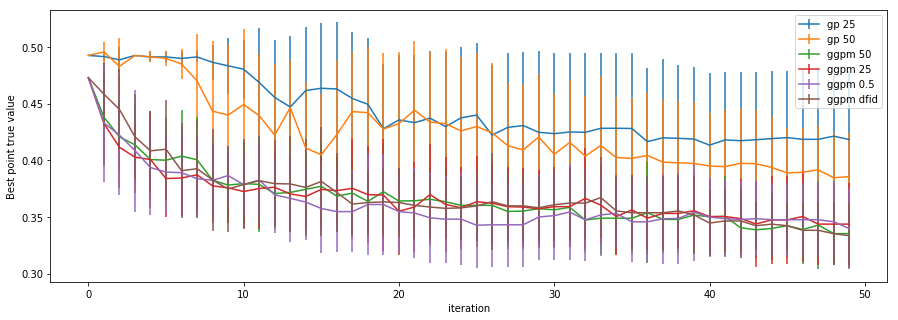

In [129]:
means, stds = return_track(agg, sqmichalewicz5)

plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(len(means[0])),  means[0], yerr=stds[0], label='gp 25')
plt.errorbar(np.arange(len(means[1])),  means[1], yerr=stds[1], label='gp 50')
plt.errorbar(np.arange(len(means[2])),  means[2], yerr=stds[2], label='ggpm 50')
plt.errorbar(np.arange(len(means[3])),  means[3], yerr=stds[3], label='ggpm 25')
plt.errorbar(np.arange(len(means[4])),  means[4], yerr=stds[4], label='ggpm 0.5')
plt.errorbar(np.arange(len(means[5])),  means[5], yerr=stds[5], label='ggpm dfid')
# plt.yscale('log', nonposy='clip')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

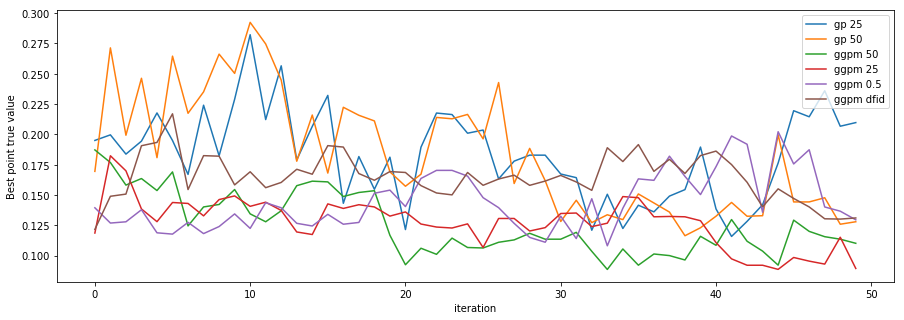

In [98]:
means, stds = return_track(agg, eg1)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(means[0])),  means[0], label='gp 25')
plt.plot(np.arange(len(means[1])),  means[1], label='gp 50')
plt.plot(np.arange(len(means[2])),  means[2], label='ggpm 50')
plt.plot(np.arange(len(means[3])),  means[3], label='ggpm 25')
plt.plot(np.arange(len(means[4])),  means[4], label='ggpm 0.5')
plt.plot(np.arange(len(means[5])),  means[5], label='ggpm dfid')
# plt.yscale('log', nonposy='clip')
plt.ylabel('Best point true value')
plt.xlabel('iteration')
plt.legend()

Text(0.5,0,'Computation resources')

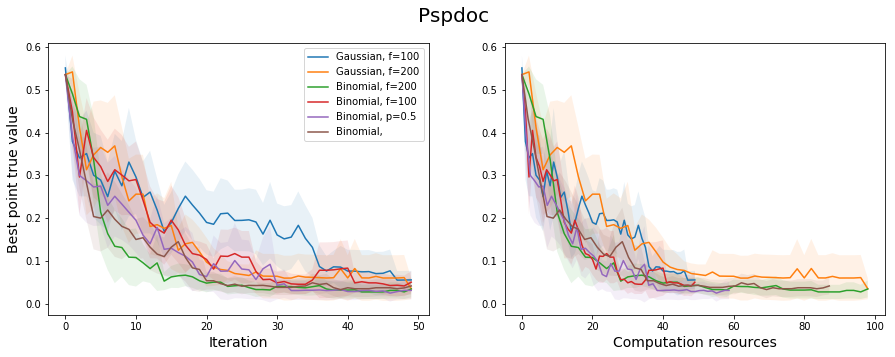

In [125]:
means, stds = return_track(agg, pspdoc)
stds /= 2.

plt.figure(figsize=(15, 5))
plt.suptitle("Pspdoc", fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, p=0.5')
plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Best point true value', fontsize=14)
plt.legend()
plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=14)
# plt.yscale('log', nonposy='clip')

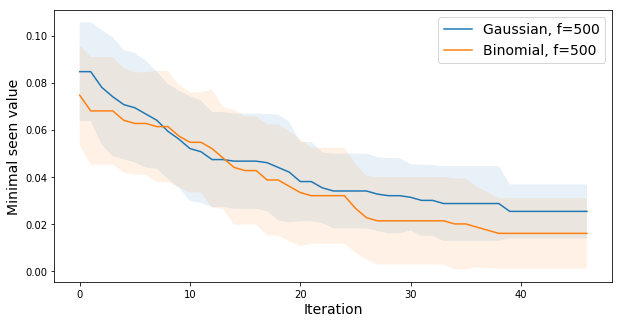

In [129]:
# numpy.minimum.accumulate()
cut=10
plt.figure(figsize=(10, 5))
# m = np.array([np.minimum.accumulate(agg[0, i, 2] / agg[0, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[cut:].ravel()
# s = np.array([np.minimum.accumulate(agg[0, i, 2] / agg[0, i, 3]) for i in range(agg.shape[1])]).std(axis=0)[cut:].ravel()
# plt.plot(m, label='Binomial, f=100')
# plt.fill_between(np.arange(len(m)), m+s, m-s, alpha=0.1)
# plt.plot(np.array([np.minimum.accumulate(agg_l[0, i, 2] / agg_l[0, i, 3]) for i in range(agg_l.shape[1])]).mean(axis=0)[10:], label='100, Binomial')

m = np.array([np.minimum.accumulate(agg[1, i, 2] / agg[1, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[cut:].ravel()
s = np.array([np.minimum.accumulate(agg[1, i, 2] / agg[1, i, 3]) for i in range(agg.shape[1])]).std(axis=0)[cut:].ravel()
plt.plot(m, label='Gaussian, f=500')
plt.fill_between(np.arange(len(m)), m+s, m-s, alpha=0.1)
# plt.plot(np.array([np.minimum.accumulate(agg_l[1, i, 2] / agg_l[1, i, 3]) for i in range(agg_l.shape[1])]).mean(axis=0)[10:], label='500, Binomial')

# m = np.array([np.minimum.accumulate(agg[2, i, 2] / agg[2, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[cut:].ravel()
# s = np.array([np.minimum.accumulate(agg[2, i, 2] / agg[2, i, 3]) for i in range(agg.shape[1])]).std(axis=0)[cut:].ravel()
# plt.plot(m, label='Gaussian, f=100')
# plt.fill_between(np.arange(len(m)), m+s, m-s, alpha=0.1)
# plt.plot(np.array([np.minimum.accumulate(agg[0, i, 2] / agg[0, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[10:], label='100, Gaussian')

m = np.array([np.minimum.accumulate(agg[3, i, 2] / agg[3, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[cut:].ravel()
s = np.array([np.minimum.accumulate(agg[3, i, 2] / agg[3, i, 3]) for i in range(agg.shape[1])]).std(axis=0)[cut:].ravel()
plt.plot(m, label='Binomial, f=500')
plt.fill_between(np.arange(len(m)), m+s, m-s, alpha=0.1)
# plt.plot(np.array([np.minimum.accumulate(agg[1, i, 2] / agg[1, i, 3]) for i in range(agg.shape[1])]).mean(axis=0)[10:], label='500, Gaussian')
# plt.title(r'1-$\pi$')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Minimal seen value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Text(0.5,0,'Computation resources')

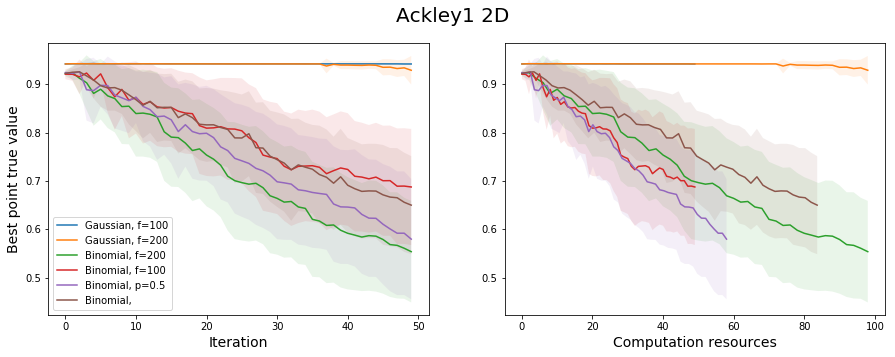

In [475]:
means, stds = return_track(agg, ackley1)
stds /= 2.

plt.figure(figsize=(15, 5))
plt.suptitle("Ackley1 2D", fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, p=0.5')
plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Best point true value', fontsize=14)
plt.legend()
plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=14)
# plt.yscale('log', nonposy='clip')

In [527]:
from scipy.stats import ttest_ind

In [535]:
ttest_ind(a5, a2, equal_var=False)

Ttest_indResult(statistic=2.3078610439735794, pvalue=0.023112336482763923)

In [419]:
tracks = []
for i in range(len(agg)):
    subtracks = []
    for j in range(len(agg[i])):
        argmins = agg[i, j, 1][agg[i, j, 4]]
        values = ackley1(argmins)
        subtracks.append(values)
    tracks.append(subtracks)

In [530]:
a2 = [a[-1] for a in tracks[2]]

In [531]:
a5 = [a[-1] for a in tracks[5]]

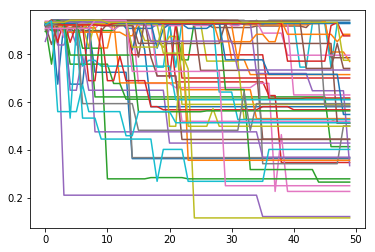

In [473]:
plt.plot(np.array(tracks[2]).T)
plt.show()

In [504]:
X = np.array(list(np.arange(50))*50).reshape(-1, 1)
y = []
for k in tracks[2]:
    y += list(k)
    
y = np.array(y).reshape(-1, 1)

In [523]:
import GPy

regr = GPy.models.GPRegression(X[subset], y[subset], GPy.kern.RBF(1))

In [524]:
subset = np.random.choice(2500, 500, False)

In [525]:
regr.optimize_restarts(5)

Optimization restart 1/5, f = -56.959281300613156
Optimization restart 2/5, f = -56.95928125860854
Optimization restart 3/5, f = -56.959281300614634
Optimization restart 4/5, f = -56.95928130019411
Optimization restart 5/5, f = 62.39757520584192


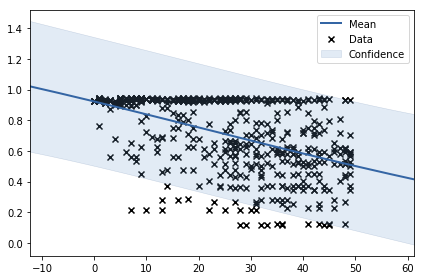

In [526]:
regr.plot()

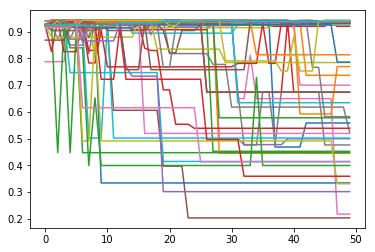

In [474]:
plt.plot(np.array(tracks[3]).T)
plt.show()

(array([  1.,   1.,   1.,   1.,   9.,   8.,   6.,  10.,   3.,  10.]),
 array([ 0.07971858,  0.16604415,  0.25236971,  0.33869528,  0.42502085,
         0.51134641,  0.59767198,  0.68399755,  0.77032311,  0.85664868,
         0.94297425]),
 <a list of 10 Patch objects>)

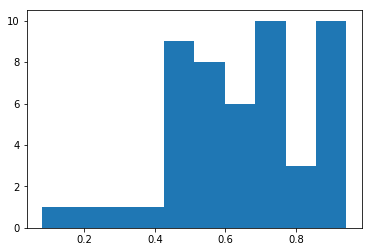

In [444]:
plt.hist(np.array(tracks[5])[:, 49])

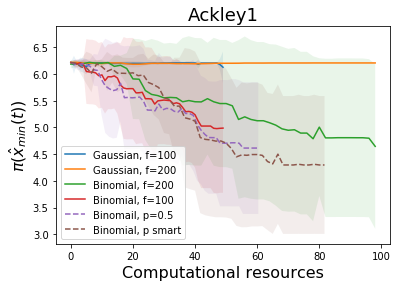

In [348]:
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5', ls='--')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, p smart', ls='--')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computational resources', fontsize=16)
plt.ylabel(r"$\pi(\hat{x}_{min}(t))$", fontsize=16)
plt.title("Ackley1", fontsize=18)
plt.legend()

In [212]:
# ackley1_1_2_100_200_ind0
max_fidelity = 200
min_fidelity = 100
mean_fidelities = []
for i in range(agg.shape[0]):
    mean_fidelities.append(agg[i, :, 3].mean().mean())

In [215]:
for i in range(agg.shape[0]):
    idx = int((len(means[i])-1)/mean_fidelities[i]*min_fidelity)
    print(i, means[i][idx], stds[i][idx])

0 0.925845619154 0.0555324080579
1 0.939956150317 0.00311016985673
2 0.797286658581 0.225058963566
3 0.710328272901 0.229147655197
4 0.656823824992 0.223357765457
5 0.664740470768 0.270150939414


Text(0.5,0,'Computation resources')

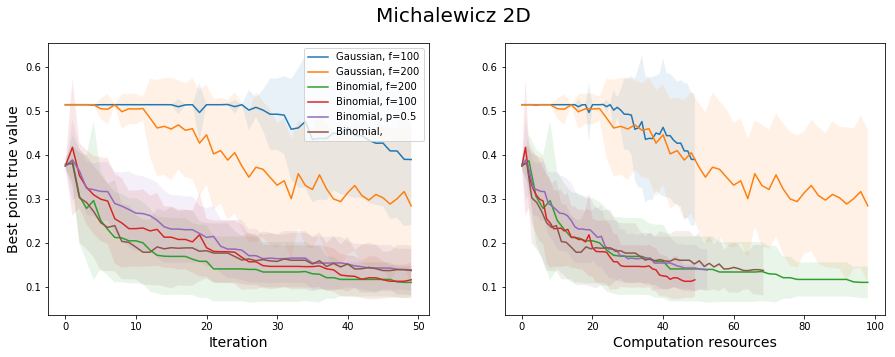

In [341]:
means, stds = return_track(agg, michalewicz)

plt.figure(figsize=(15, 5))
plt.suptitle("Michalewicz 2D", fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, p=0.5')
plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Best point true value', fontsize=14)
plt.legend()
plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=14)
# plt.yscale('log', nonposy='clip')

Text(0.5,1,'Michalewicz')

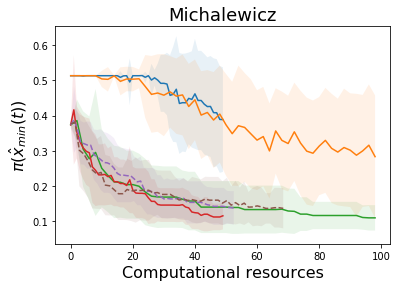

In [343]:
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5', ls='--')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, p smart', ls='--')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computational resources', fontsize=16)
plt.ylabel(r"$\pi(\hat{x}_{min}(t))$", fontsize=16)
plt.title("Michalewicz", fontsize=18)
# plt.legend()

In [230]:
# 'michalewicz_2_2_100_200_ind4'
max_fidelity = 200
min_fidelity = 100
mean_fidelities = []
for i in range(agg.shape[0]):
    mean_fidelities.append(agg[i, :, 3].mean().mean())

In [231]:
for i in range(agg.shape[0]):
    idx = int((len(means[i])-1)/mean_fidelities[i]*min_fidelity)
    print(i, means[i][idx], stds[i][idx])

0 0.362195581441 0.148496520131
1 0.377804110404 0.137639964157
2 0.11382051104 0.073716455087
3 0.0891159986653 0.0387537004018
4 0.115822240645 0.0524109405506
5 0.125053210628 0.0619236533291


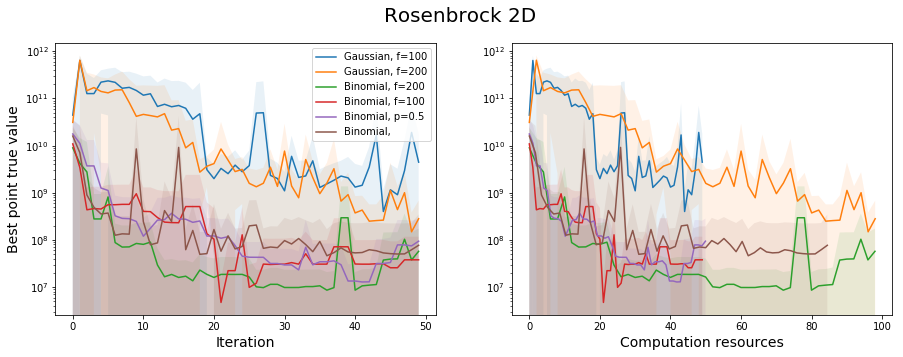

In [331]:
means, stds = return_track(agg, rosenbrock)

plt.figure(figsize=(15, 5))
plt.suptitle("Rosenbrock 2D", fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, p=0.5')
plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Best point true value', fontsize=14)
plt.legend()
plt.yscale('log', nonposy='clip')
plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=14)
plt.yscale('log', nonposy='clip')

Text(0.5,1,'Rosenbrock')

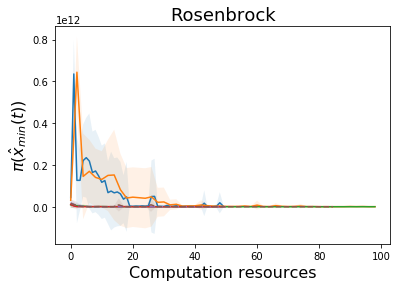

In [332]:
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5', ls='--')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, p smart', ls='--')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=16)
plt.ylabel(r"$\pi(\hat{x}_{min}(t))$", fontsize=16)
plt.title("Rosenbrock", fontsize=18)
# plt.legend()

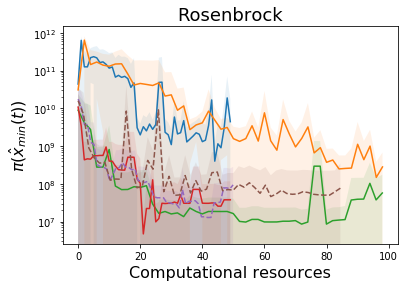

In [336]:
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5', ls='--')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, p smart', ls='--')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computational resources', fontsize=16)
plt.ylabel(r"$\pi(\hat{x}_{min}(t))$", fontsize=16)
plt.title("Rosenbrock", fontsize=18)
plt.yscale('log', nonposy='clip')
# plt.legend()

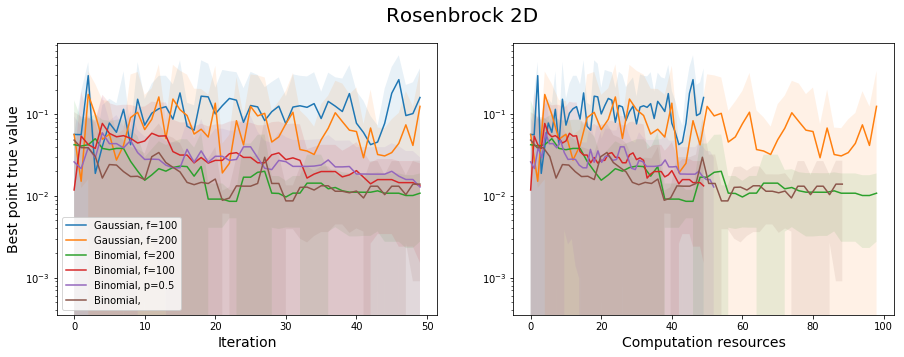

In [60]:
means, stds = return_track(agg, biggs5)

plt.figure(figsize=(15, 5))
plt.suptitle("Rosenbrock 2D", fontsize=20)
plt.subplot(1,2,1)
# plt.title("Best point value per iteration", fontsize=18)
plt.plot(np.arange(len(means[0])),  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0])), means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1])),  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1])), means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2])),  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2])), means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3])),  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3])), means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4])),  means[4], label='Binomial, p=0.5')
plt.fill_between(np.arange(len(means[4])), means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5])),  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5])), means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Best point true value', fontsize=14)
plt.legend()
plt.yscale('log', nonposy='clip')
plt.subplot(1,2,2)
# plt.title("Best point value per iteration")
max_f = np.max(agg[1, 0, 3])
min_f = np.min(agg[0, 0, 3])
plt.plot(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f,  means[0], label='Gaussian, f=100')
plt.fill_between(np.arange(len(means[0]))*agg[0, :, 3].mean().mean()/min_f, means[0]+stds[0], means[0]-stds[0], alpha=0.1)
plt.plot(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f,  means[1], label='Gaussian, f=200')
plt.fill_between(np.arange(len(means[1]))*agg[1, :, 3].mean().mean()/min_f, means[1]+stds[1], means[1]-stds[1], alpha=0.1)
plt.plot(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f,  means[2], label='Binomial, f=200')
plt.fill_between(np.arange(len(means[2]))*agg[2, :, 3].mean().mean()/min_f, means[2]+stds[2], means[2]-stds[2], alpha=0.1)
plt.plot(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f,  means[3], label='Binomial, f=100')
plt.fill_between(np.arange(len(means[3]))*agg[3, :, 3].mean().mean()/min_f, means[3]+stds[3], means[3]-stds[3], alpha=0.1)
plt.plot(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f,  means[4], label='Binomail, p=0.5')
plt.fill_between(np.arange(len(means[4]))*agg[4, :, 3].mean().mean()/min_f, means[4]+stds[4], means[4]-stds[4], alpha=0.1)
plt.plot(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f,  means[5], label='Binomial, ')
plt.fill_between(np.arange(len(means[5]))*agg[5, :, 3].mean().mean()/min_f, means[5]+stds[5], means[5]-stds[5], alpha=0.1)
plt.xlabel('Computation resources', fontsize=14)
plt.yscale('log', nonposy='clip')

In [246]:
# rosenbrock_100_2_100_200_ind3
max_fidelity = 200
min_fidelity = 100
mean_fidelities = []
for i in range(agg.shape[0]):
    mean_fidelities.append(agg[i, :, 3].mean().mean())

In [247]:
for i in range(agg.shape[0]):
    idx = int((len(means[i])-1)/mean_fidelities[i]*min_fidelity)
    print(i, means[i][idx], stds[i][idx])

0 0.00582554729268 0.0173375466785
1 0.00409731547437 0.00334377537313
2 2.4392023109e-05 3.25153040127e-05
3 4.96407772388e-05 0.000103647443349
4 9.80318456086e-05 0.000234658974268
5 9.27342393693e-05 0.000161966071297


In [280]:
df = pd.DataFrame(columns=['method', 'Ackley1', 'Michalewicz', 'Rosenbrock'])
df['method'] = ['Gaussian, f=100', 'Gaussian, f=200', 'Binomial, f=200', 'Binomial, f=100', 'Binomial, p=0.5', 'Binomial, dfid']
df['Ackley1'] = [r'$0.925\pm$ 0.055', r'$0.939\pm$ 0.003', r'$0.797\pm$ 0.225', r'$0.710\pm$ 0.229', r'$0.656\pm$ 0.223', r'$0.664\pm$ 0.270'] 
df['Michalewicz'] = [r'$0.362\pm$ 0.148', r'$0.377\pm$ 0.137', r'$0.113\pm$ 0.073', r'$0.089\pm$ 0.038', r'$0.115\pm$ 0.052', r'$0.125\pm$ 0.0619']
df['Rosenbrock'] = [r'$0.005825\pm$ 0.017337', r'$0.004097\pm$ 0.003343', r'$0.000024\pm$ 0.000032', r'$0.000049\pm$ 0.000103', r'$0.000098\pm$ 0.000234', r'$0.000092\pm$ 0.000161']

In [281]:
df

,method,Ackley1,Michalewicz,Rosenbrock
0,"Gaussian, f=100",$0.925\pm$ 0.055,$0.362\pm$ 0.148,$0.005825\pm$ 0.017337
1,"Gaussian, f=200",$0.939\pm$ 0.003,$0.377\pm$ 0.137,$0.004097\pm$ 0.003343
2,"Binomial, f=200",$0.797\pm$ 0.225,$0.113\pm$ 0.073,$0.000024\pm$ 0.000032
3,"Binomial, f=100",$0.710\pm$ 0.229,$0.089\pm$ 0.038,$0.000049\pm$ 0.000103
4,"Binomial, p=0.5",$0.656\pm$ 0.223,$0.115\pm$ 0.052,$0.000098\pm$ 0.000234
5,"Binomial, dfid",$0.664\pm$ 0.270,$0.125\pm$ 0.0619,$0.000092\pm$ 0.000161


In [ ]:
0 0.362195581441 0.148496520131
1 0.377804110404 0.137639964157
2 0.11382051104 0.073716455087
3 0.0891159986653 0.0387537004018
4 0.115822240645 0.0524109405506
5 0.125053210628 0.0619236533291

Text(0.5,0,'$x_2$')

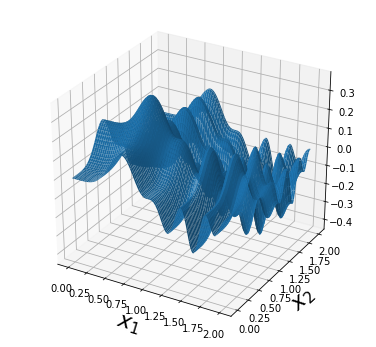

In [122]:
xs = np.linspace(0, 2, 300)
ys = np.linspace(0, 2, 300)
xs, ys = np.meshgrid(xs, ys)
values = sqmichalewicz5(np.dstack([xs, ys]).reshape(90000, 2)).reshape(300, 300)
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
p = ax.plot_surface(xs, ys, values, rstride=4, cstride=4, linewidth=0)
ax.set_xlabel(r"$x_1$", fontsize=22)
ax.set_ylabel(r"$x_2$", fontsize=22)
# ax.set_zlabel(r"$f(x)$", fontsize=22)
# print(sqmichalewicz5(argmin.reshape(1, -1)))